## Simple regression tree

Three step process:

* The predictor to split on and value of the split
* The depth or complexity of the tree
* The prediction equation in the terminal nodes (skipped)

Search every distinct value of every predictor to find the predictor and split value that partitions data into two groups such that following error is minimized

$$ SSE = \sum_{i\in S_1} \left( y_i - \overline{y}_1 \right)^2 + \sum_{i\in S_2} \left( y_i - \overline{y}_2 \right)^2.$$

Boston dataset from sklearn will be used as sample data.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
raw_data = datasets.load_boston()
df = pd.DataFrame(raw_data['data'], columns = raw_data['feature_names']) 
cols = df.columns.values   # original columns, might be necessary later
df['target'] = raw_data['target']
np.random.seed(42)
sample = np.random.rand(len(df))    # split data to train and test sets
train_data = df[sample < 0.7].copy()
test_data = df[sample >= 0.3].copy()

Define method that enables to evaluate a split given the value

In [26]:
def mean_error(vector):
    return sum((vector - vector.mean())**2)

def eval_split(df, split):
    return (mean_error(df[df.ix[:,0] >= split]['target']) 
            + mean_error(df[df.ix[:,0] < split]['target']))

In [27]:
def optimal_split(df):
    errors = []
    for column in df.columns.values[:list(df.columns.values).index('target')]:    # train only with columns that are before column 'target', see below
        tmp_errors = []
        for split in np.linspace(df[column].min(), df[column].max(), 100):
            tmp_errors.append([eval_split(df[[column, 'target']], split), 
                               split, column])
        errors.append(min(tmp_errors))
    return min(errors)

We will check if this split acctually shows relevant difference in target distribution.

In [28]:
opt_split = optimal_split(train_data)

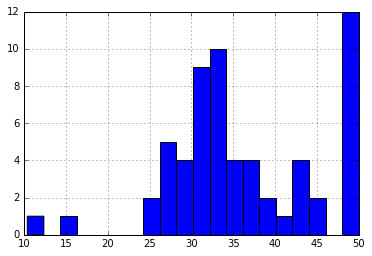

In [29]:
train_data[train_data[opt_split[2]] >= opt_split[1]]['target'].hist(bins = 20)

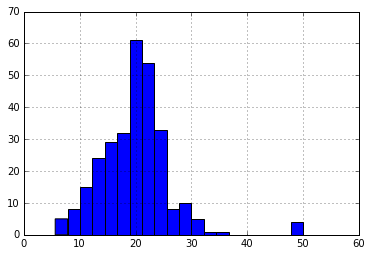

In [30]:
train_data[train_data[opt_split[2]] < opt_split[1]]['target'].hist(bins=20)

Each *split n* column will represent consecutive split. If leaf has less than $n$ nodes then it will get label *full*.

In [31]:
def make_split(df, leaf_size):
    if df.shape[0] > leaf_size:
        opt_split = optimal_split(df)
        return (df[opt_split[2]] < opt_split[1]).apply(lambda l:
        '{0}<{1}'.format(opt_split[2], round(opt_split[1],2)) if l else '{0}>={1}'.format(opt_split[2], round(opt_split[1],2)))
    else:
        return df['target'].apply(lambda t: 'full')

Following cycle repeats splits until all leafs are *full*.

In [32]:
def train(train_data, leaf_size = 50):
    train_data['split 1'] = make_split(train_data, leaf_size)
    i = 2
    while sum(train_data['split {0}'.format(i - 1)] == 'full') != train_data.shape[0]:
        train_data['split {0}'.format(i)] = train_data.groupby(['split {0}'.format(l) for l in range(1, i)]).apply(
            lambda d: make_split(d, leaf_size)).reset_index().set_index('level_{0}'.format(i-1)).ix[:, -1]
        i += 1
    rules = train_data.groupby(['split {0}'.format(l) for l in range(1, i-1)])['target'].mean().reset_index()
    rules['parsed'] = rules[['split {0}'.format(l) for l in range(1, i-1)]].apply(
        lambda row: ' and '.join([l for l in row if l != 'full']), axis=1)
    return rules[['parsed', 'target']]

def predict(test_data, rules):
    for i in range(rules.shape[0]):
        test_data.loc[test_data.query(rules['parsed'][i]).index, 'prediction'] = rules['target'][i]

In [48]:
rules = train(train_data)
rules.head()

,parsed,target
0,RM<6.8 and LSTAT<14.83 and DIS<1.46,40.483333
1,RM<6.8 and LSTAT<14.83 and DIS>=1.46 and RM<6....,23.185714
2,RM<6.8 and LSTAT<14.83 and DIS>=1.46 and RM<6....,18.831250
3,RM<6.8 and LSTAT<14.83 and DIS>=1.46 and RM<6....,22.370000
4,RM<6.8 and LSTAT<14.83 and DIS>=1.46 and RM<6....,20.520455


In [34]:
predict(test_data, rules)

In [35]:
print('RMSE {0}'.format(np.mean((test_data['target'] - test_data['prediction'])**2)))

RMSE 17.876409656947654


Can we improve this score by expanding the structure?

In [18]:
for leaf_size in [200, 100, 50, 20, 10]:
    rules = train(train_data, leaf_size)
    predict(test_data, rules)
    print('Leaf size {0} RMSE {1}'.format(leaf_size, np.mean((test_data['target'] - test_data['prediction'])**2)))

Leaf size 200 RMSE 30.269380373831417
Leaf size 100 RMSE 28.68319500003491
Leaf size 50 RMSE 17.876409656947654
Leaf size 20 RMSE 13.212834654503839
Leaf size 10 RMSE 11.2863938883272


Small leaf size leads to long computation time, thus $10$ will be used as optimal value.

## Regression tree with bagging

General idea is as follows:

1. Generate subset of data
2. Construct a tree
3. Repeat steps 1 and 2 for k times
4. Cumpute final scores

In [43]:
predictions = pd.DataFrame()
for i in range(10):    # ATTENTION: long run time, start with smaller values
    predict(test_data, train(train_data.sample(100), leaf_size = 10))
    predictions['bag_{0}'.format(i)] = test_data['prediction']

In [44]:
print('Bagging RMSE {0}'.format(np.mean((test_data['target'] - predictions.mean(axis = 1))**2)))

Bagging RMSE 9.771014391227752


## Random forest

General idea is as follows:

1. Generate subset of data and subset of features!
2. Construct a tree
3. Repeat steps 1 and 2 for k times
4. Cumpute final scores

In [46]:
predictions = pd.DataFrame()
for i in range(10):    # ATTENTION: long run time, start with smaller values
    tmp_data = train_data.sample(100).ix[:, np.append(np.random.choice(cols, size=5, replace=False), 'target')].copy()
    predict(test_data, train(tmp_data, leaf_size=10))
    predictions['rand_{0}'.format(i)] = test_data['prediction']

In [47]:
print('Random Forest RMSE {0}'.format(np.mean((test_data['target'] - predictions.mean(axis = 1))**2)))

Random Forest RMSE 12.072897488930254


## Next steps

* Inspect why rf structure gave no improvement
* Implement pruning
* Use predictive function instead of mean for the last leaf
* Rewrite with tree class instead of data frames
* Optimize to improve run time (currently single case takes ~30s)
* Rewrite for classification problem